# Telco Customer Churn Using Tabular Neural Nets

## Load Data

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preview
print(f"Shape: {df.shape}")
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Clean Data + EDA

In [2]:
# Replace spaces in column names with underscores for ease
df.columns = df.columns.str.replace(' ', '_')

# Check types and missing values
df.info()
df.isnull().sum()

# Fix TotalCharges (some blank strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Check class balance
df['Churn'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


/var/folders/tx/bg_9dv292q3ct7x5bj7l118h0000gn/T/ipykernel_23100/1175081971.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

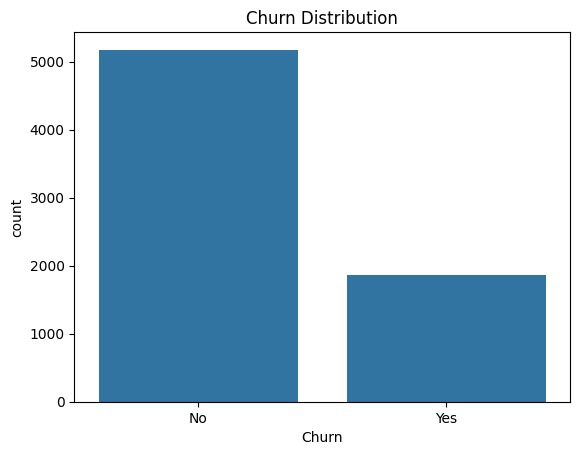

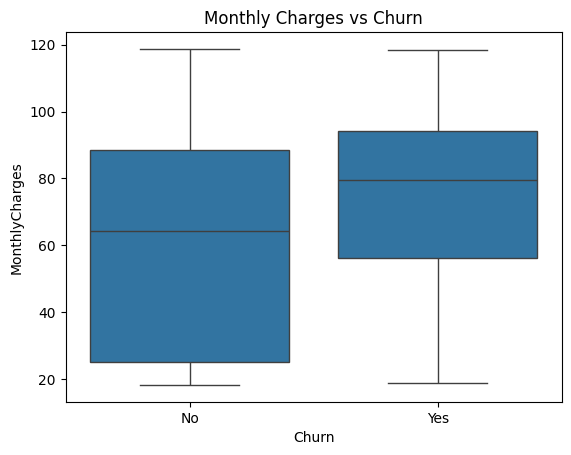

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

# Compare MonthlyCharges by Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


## Encode and Split Data 

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Drop customerID
df = df.drop(columns=['customerID'])

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split data
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=4)


## Train Random Forest for Comparison

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train RF model
rf = RandomForestClassifier(n_estimators=100, random_state=8)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_valid)
print(classification_report(y_valid, y_pred))
print("ROC AUC:", roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1]))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

ROC AUC: 0.8242928001240022


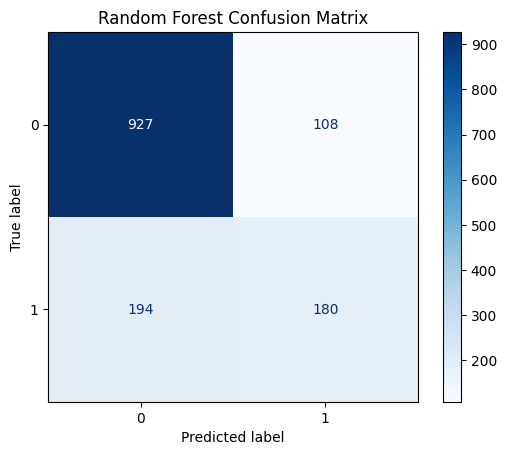

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_valid, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()


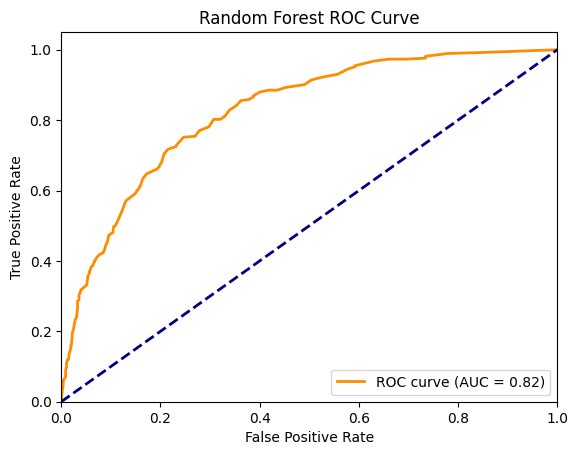

In [9]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
rf_probs = rf.predict_proba(X_valid)[:, 1]

# Compute ROC
fpr, tpr, _ = roc_curve(y_valid, rf_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()


## Tabular Neural Net with FastAI

In [42]:
from fastai.tabular.all import *

# Clean up Churn target for categorical modeling
df['Churn'] = df['Churn'].map({'No': 'No', 'Yes': 'Yes'})  # ensure string format

# Define columns
cat_names = df.select_dtypes(include='object').columns.tolist()
cat_names.remove('Churn')
cont_names = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split
splits = RandomSplitter(seed=42)(range_of(df))

# Create DataLoaders
dls = TabularDataLoaders.from_df(
    df,
    path='.',
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names='Churn',
    y_block=CategoryBlock(),
    splits=splits,
    bs=64
)

# Build the learner (dropout + early stopping)
learn = tabular_learner(
    dls,
    layers=[500, 250],
    config=tabular_config(ps=[0.3, 0.3]),
    wd=0.01,
    metrics=[accuracy, RocAucBinary()],
    cbs=EarlyStoppingCallback(monitor='roc_auc_score', patience=3)
)

# Train
learn.fit_one_cycle(10, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.633009,0.584340,0.731534,0.801738,00:01
1,0.547349,0.524618,0.766335,0.777843,00:01
2,0.486405,0.427361,0.794744,0.839209,00:01
3,0.457378,0.433533,0.791193,0.833564,00:01
4,0.448537,0.433255,0.780540,0.827688,00:01
5,0.433995,0.422136,0.786222,0.841968,00:01
6,0.423224,0.417177,0.789062,0.844129,00:01
7,0.415894,0.418486,0.788352,0.841827,00:01
8,0.421441,0.416136,0.796165,0.843152,00:01
9,0.423350,0.418851,0.789062,0.842571,00:01


No improvement since epoch 6: early stopping


,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Churn_pred
0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,-0.434532,-0.141844,0.304751,-0.134831,0.0,0.0
1,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,-0.434532,-1.199592,0.472857,-0.897368,1.0,1.0
2,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,2.0,3.0,-0.434532,0.061569,-0.672259,-0.378155,0.0,0.0
3,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,2.0,2.0,-0.434532,1.322730,-0.174600,0.667167,0.0,0.0
4,2.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,3.0,-0.434532,-0.304575,0.657607,-0.112648,1.0,1.0
5,1.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,-0.434532,-0.426622,-0.860338,-0.640059,0.0,0.0
6,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,2.0,3.0,-0.434532,-1.158909,-0.124667,-0.905411,0.0,0.0
7,1.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,-0.434532,-1.118227,-1.514453,-0.971605,0.0,0.0
8,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,3.0,1.0,3.0,3.0,2.0,2.0,3.0,-0.434532,1.200682,1.168582,1.818474,1.0,0.0


ROC AUC Score (FastAI NN): 0.8426


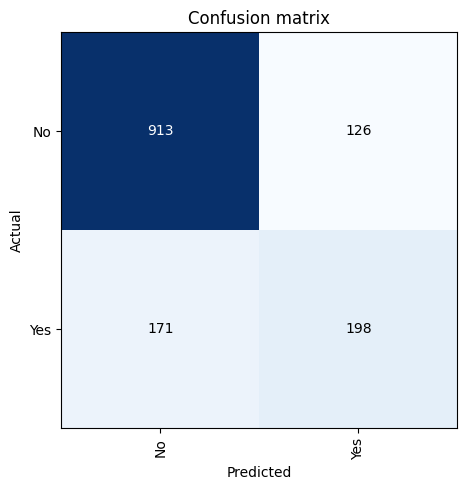

In [43]:
# Show results
learn.show_results()

# Classification report
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

from sklearn.metrics import roc_auc_score

# Get predictions and true labels
preds, targs = learn.get_preds()

# Convert predictions to probabilities for class "1"
pred_probs = preds[:, 1]  # second column = prob of "Yes" (churn)

# Convert to numpy
roc_auc = roc_auc_score(targs.numpy(), pred_probs.numpy())
print(f"ROC AUC Score (FastAI NN): {roc_auc:.4f}")


In [46]:
from sklearn.metrics import accuracy_score

# Convert predictions to class labels
tnn_preds_class = tnn_preds.argmax(dim=1).numpy()

# Compute accuracy
tnn_accuracy = accuracy_score(tnn_true, tnn_preds_class)
print(f"Tabular Neural Net Accuracy: {tnn_accuracy:.4f}")


Tabular Neural Net Accuracy: 0.7891


Tabular Neural Net ROC AUC: 0.8426


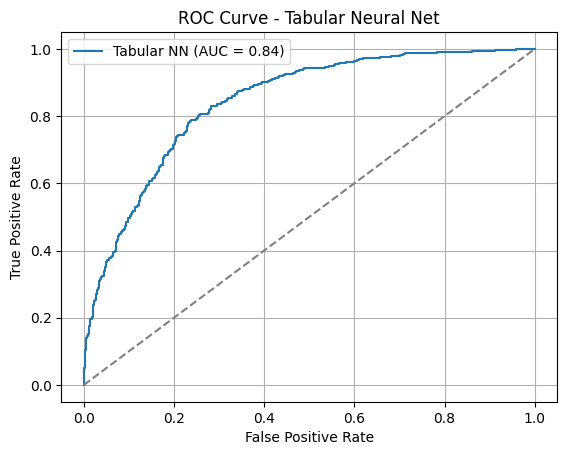

In [44]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Get FastAI predictions and targets
preds, targs = learn.get_preds()

# Use probability of class 1 (churn)
pred_probs_nn = preds[:, 1].numpy()
targs_nn = targs.numpy()

# Compute AUC
roc_auc_nn = roc_auc_score(targs_nn, pred_probs_nn)
print(f"Tabular Neural Net ROC AUC: {roc_auc_nn:.4f}")

# Plot ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(targs_nn, pred_probs_nn)
plt.plot(fpr_nn, tpr_nn, label=f'Tabular NN (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tabular Neural Net")
plt.legend()
plt.grid(True)
plt.show()


## Compare Models

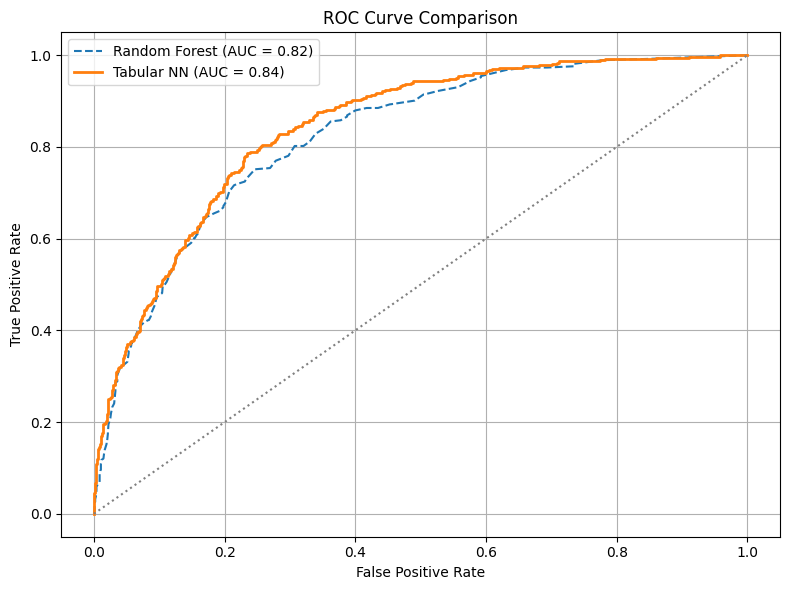

,Model,Accuracy,ROC AUC
0,Random Forest,0.79,0.824293
1,Tabular Neural Net,0.79,0.842571


In [47]:
# ROC overlay + summary table for RF vs TNN

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Random Forest
rf_probs = rf.predict_proba(X_valid)[:, 1]
rf_auc = roc_auc_score(y_valid, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_valid, rf_probs)

# Tabular Neural Net
tnn_preds, tnn_targs = learn.get_preds()
tnn_probs = tnn_preds[:, 1].numpy()
tnn_true = tnn_targs.numpy()
tnn_auc = roc_auc_score(tnn_true, tnn_probs)
tnn_fpr, tnn_tpr, _ = roc_curve(tnn_true, tnn_probs)

# Plot ROC Curve Comparison
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, linestyle="--", label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(tnn_fpr, tnn_tpr, linewidth=2, label=f"Tabular NN (AUC = {tnn_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Comparison Table
comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "Tabular Neural Net"],
    "Accuracy": [0.79, 0.79], 
    "ROC AUC": [rf_auc, tnn_auc]
})
display(comparison_df)


## Feature Importance for Random Forest

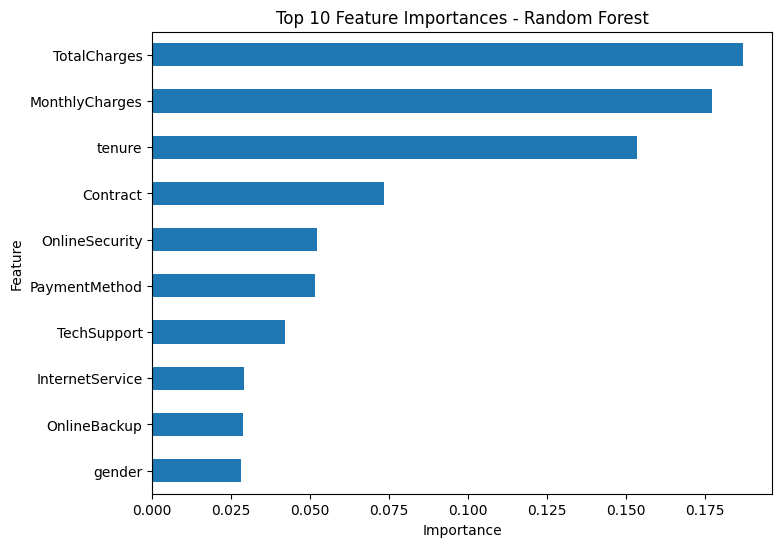

In [48]:
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=True).tail(10).plot(
    kind='barh', x='Feature', y='Importance', legend=False, figsize=(8, 6)
)
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()


## Feature Importance for Tabular Neural Net

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

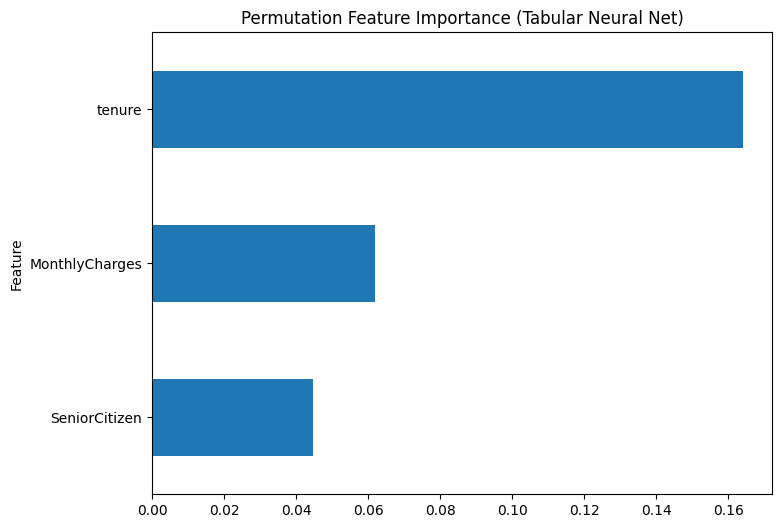

In [67]:
import copy
from sklearn.metrics import roc_auc_score

# Get original validation data
X_val, y_val = dls.valid_ds.items[dls.xs.columns], dls.valid_ds.items[dls.y_names].values

# Get baseline predictions
dl_val = learn.dls.test_dl(X_val)
preds_base, _ = learn.get_preds(dl=dl_val)
auc_base = roc_auc_score(y_val, preds_base[:, 1])

# Run permutation importance
importances = []

for col in X_val.columns:
    X_perm = X_val.copy()
    X_perm[col] = np.random.permutation(X_perm[col].values)

    dl_perm = learn.dls.test_dl(X_perm)
    preds_perm, _ = learn.get_preds(dl=dl_perm)
    
    try:
        auc_perm = roc_auc_score(y_val, preds_perm[:, 1])
        drop = auc_base - auc_perm
        importances.append((col, drop))
    except:
        # Catch ROC AUC errors (e.g. if only one class in y_val)
        importances.append((col, 0))

# Create and sort DataFrame
importances_df = pd.DataFrame(importances, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plot
importances_df.head(3).plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(8, 6))
plt.title('Permutation Feature Importance (Tabular Neural Net)')
plt.gca().invert_yaxis()
plt.tight_layout


To interpret the Tabular Neural Net, we performed permutation-based feature importance. The model consistently identified **tenure**, **monthly charges**, and **senior citizen status** as the most impactful features driving churn predictions.

These findings are consistent with domain knowledge — newer customers with higher bills, particularly among specific demographics, are more likely to churn.

Despite the large number of features in the dataset, the TNN appears to rely primarily on these three, suggesting it has learned to prioritize the strongest predictors and ignore noise or redundant variables.


## Conclusion

In this analysis of Telco Customer Churn, we developed and compared two supervised learning models: a Random Forest classifier and a Tabular Neural Network (TNN). The objective was to predict whether a customer would churn based on demographic and service-related attributes.

**Model performance summary:**

- **Random Forest**
  - Accuracy: 79%
  - ROC AUC: 0.824

- **Tabular Neural Network**
  - Accuracy: 79%
  - ROC AUC: 0.843

Although both models achieved the same classification accuracy, the TNN slightly outperformed the Random Forest in terms of ROC AUC, suggesting it was better at ranking customers by their likelihood to churn.

One particularly interesting observation is that the TNN concentrated most of its predictive power on just three features: `tenure`, `monthlycharges`, and `seniorcitizen`. In contrast, the Random Forest spread feature importance more evenly across a wider set of variables. This distinction highlights a key strength of neural networks: the ability to learn compact, non-linear representations from complex inputs.

This result is notable from a business perspective as well. If the TNN's feature reliance is taken as a signal of true predictive power, then efforts to reduce churn may be best directed toward newer customers with higher monthly charges and those identified as senior citizens.

Ultimately, both models performed well, but the TNN's more efficient use of features and higher ROC AUC make it a compelling choice for deployment or further refinement.
